Load data.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
df = pd.read_csv("../raw_data/svi_md.csv") # import SVI data
df = df.loc[df['STCNTY'] == 24510] # filter by baltimore city
df = df.replace(-999, np.nan)
drop_fips = [
             24510250600,  # South harbor
             24510100300   # Prison
             ] # Dropping these FIPS due to missing data

drop_indices = df.index[df["FIPS"].isin(drop_fips)]
df = df.drop(index=drop_indices)

# Extract Percentage Data
ep_df = df.loc[:, df.columns.str.contains('FIPS|EP_.*')]

SVI_scores = pd.read_csv('../raw_data/SVI_scores.csv')
SVI_scores = SVI_scores[['FIPS','RPL_THEMES','SPL_THEMES']]

ep_df = ep_df.merge(SVI_scores, on='FIPS')

ep_df.head()

,FIPS,EP_POV,EP_UNEMP,EP_PCI,EP_NOHSDP,EP_AGE65,EP_AGE17,EP_DISABL,EP_SNGPNT,EP_MINRTY,EP_LIMENG,EP_MUNIT,EP_MOBILE,EP_CROWD,EP_NOVEH,EP_GROUPQ,EP_UNINSUR,RPL_THEMES,SPL_THEMES
0,24510010300,4.3,1.1,68345.0,4.5,4.7,9.8,4.4,1.8,14.9,0.9,0.7,0.0,0.6,5.5,0.0,2.0,0.005076,1.534720
1,24510240400,2.1,2.2,51469.0,10.8,7.6,11.5,3.6,1.9,6.1,0.0,13.8,0.0,0.5,4.0,0.0,5.0,0.010150,1.863785
2,24510261100,7.7,5.3,63780.0,4.8,5.6,9.7,8.5,1.4,14.7,0.0,0.0,0.0,0.5,8.4,0.0,3.4,0.000000,1.217960
3,24510271102,2.9,3.3,32299.0,0.0,5.8,5.8,2.5,1.1,39.1,0.3,0.0,0.0,0.0,1.4,74.3,3.3,0.020300,2.118966
4,24510010200,5.9,1.4,56058.0,4.5,8.0,11.9,7.7,1.1,11.3,0.3,8.0,0.0,0.7,7.8,0.0,2.5,0.015230,2.045000


We normalise all variables so they have mean 0.

In [2]:
from sklearn.preprocessing import PowerTransformer
scaler = PowerTransformer(method='box-cox')

SVI_indices = ['EP_POV', 'EP_UNEMP', 'EP_PCI', 'EP_NOHSDP', 'EP_AGE65',
       'EP_AGE17', 'EP_DISABL', 'EP_SNGPNT', 'EP_MINRTY', 'EP_LIMENG',
       'EP_MUNIT', 'EP_MOBILE', 'EP_CROWD', 'EP_NOVEH', 'EP_GROUPQ',
       'EP_UNINSUR']

df_temp = ep_df[SVI_indices]

scaled_df = pd.DataFrame(scaler.fit_transform(1 + df_temp), columns = df_temp.columns)

scaled_df['FIPS'] = list(ep_df['FIPS'])

In the plots we see below, we group the tracts into 2 parts by whether they have an "SPL" score higher than average (True means higher). we find that this separation is not closely related to variables such as "MUNIT", which was supposedly taken into account in the "SPL" score.

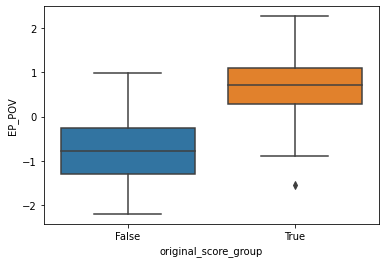

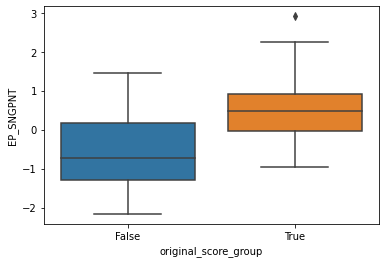

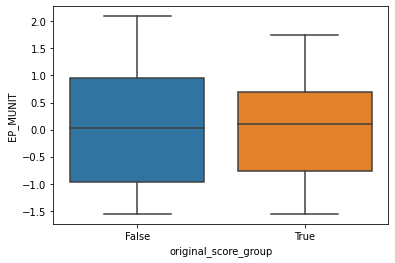

In [3]:
scaled_df['original_score_group'] = ep_df['SPL_THEMES'] > ep_df['SPL_THEMES'].mean()
for col in ['EP_POV', 'EP_SNGPNT', 'EP_MUNIT']:
    sns.boxplot(x='original_score_group', y=col, data=scaled_df)
    plt.show()

The same happens with RPL scores. 

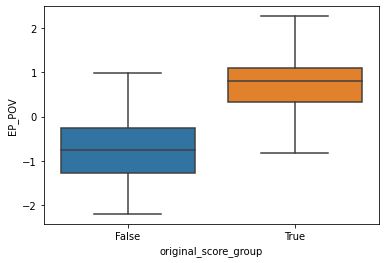

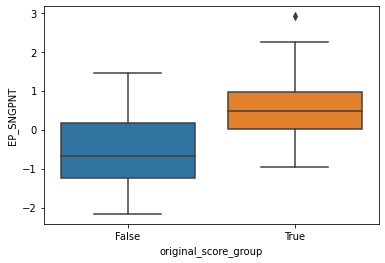

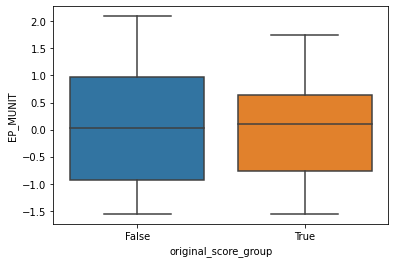

In [4]:
scaled_df['original_score_group'] = ep_df['RPL_THEMES'] > ep_df['RPL_THEMES'].mean()
for col in ['EP_POV', 'EP_SNGPNT', 'EP_MUNIT']:
    sns.boxplot(x='original_score_group', y=col, data=scaled_df)
    plt.show()

In our factor analysis (see R script), we found that variables such as 'POV', 'UNEMP', 'PCI', 'NOHSDP', 'DISABL', 'SNGPNT', 'MINRTY', 'NOVEH' are highly correlated and driven by a common hidden factor. In the subsequent analysis, we test if only using these variables would give us the same score as in the report.

In what's shown below, we simply calculate the sunm of percentiles of these variables and produce a score.

In [5]:
PL = ['EPL_POV', 'EPL_UNEMP', 'EPL_PCI', 'EPL_NOHSDP', 'EPL_DISABL', 'EPL_SNGPNT',
        'EPL_MINRTY', 'EPL_NOVEH']

PC = ['EP_POV', 'EP_UNEMP', 'EP_PCI', 'EP_NOHSDP', 'EP_DISABL', 'EP_SNGPNT',
        'EP_MINRTY', 'EP_NOVEH']

scaled_df['original_score_group'] = ep_df['SPL_THEMES'] > ep_df['SPL_THEMES'].mean()

epl_df = df[PL + ['FIPS']]
epl_df['simple_score'] = epl_df[PL].sum(axis = 1)
epl_df.head()

<ipython-input-5-06dcf1415190>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  epl_df['simple_score'] = epl_df[PL].sum(axis = 1)


,EPL_POV,EPL_UNEMP,EPL_PCI,EPL_NOHSDP,EPL_DISABL,EPL_SNGPNT,EPL_MINRTY,EPL_NOVEH,FIPS,simple_score
15,0.2522,0.0123,0.0634,0.2277,0.0231,0.0555,0.1837,0.5123,24510010300,1.3302
22,0.0838,0.0889,0.1830,0.6261,0.0123,0.0605,0.0447,0.4104,24510240400,1.5097
28,0.5036,0.5159,0.0814,0.2507,0.3071,0.0339,0.1808,0.6358,24510261100,2.5092
29,0.1395,0.2254,0.6412,0.0000,0.0029,0.0252,0.4597,0.1452,24510271102,1.6391
37,0.3844,0.0224,0.1333,0.2277,0.2334,0.0252,0.1318,0.6192,24510010200,1.7774


In [6]:
reduced = epl_df[['simple_score', 'FIPS']]

In [7]:
original_score = scaled_df[['FIPS', 'original_score_group']]

scores_check = reduced.merge(original_score, on = 'FIPS')
scores_check.head()

,simple_score,FIPS,original_score_group
0,1.3302,24510010300,False
1,1.5097,24510240400,False
2,2.5092,24510261100,False
3,1.6391,24510271102,False
4,1.7774,24510010200,False


0.965488991295443


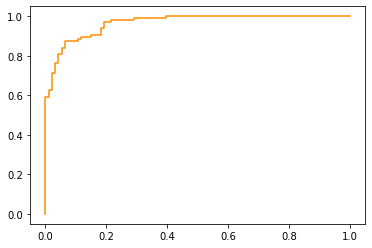

In [8]:
from sklearn.metrics import roc_auc_score, roc_curve

print(roc_auc_score(scores_check['original_score_group'], scores_check['simple_score']))
fpr, tpr, _ = roc_curve(scores_check['original_score_group'], scores_check['simple_score'])


plt.plot(
    fpr,
    tpr,
    color="darkorange"
)

In [9]:
import geopandas

path_to_data = "../shape_files/baltimore.shp"
gdf = geopandas.read_file(path_to_data)
gdf = gdf[gdf["COUNTYFP"] == "510"] # Restrict to baltimore
gdf = gdf.astype({"GEOID": int})
gdf['FIPS'] = gdf['GEOID']
gdf = pd.merge(gdf, scores_check, on="FIPS")
gdf = pd.merge(gdf, scaled_df, on="FIPS")
gdf = pd.merge(gdf, ep_df[['FIPS','SPL_THEMES']], on="FIPS")

Let's visualise this :)

In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
gdf['simple_score'] = scaler.fit_transform(gdf[['simple_score']])
gdf['SPL_THEMES'] = scaler.fit_transform(gdf[['SPL_THEMES']])

In [11]:
gdf.explore("simple_score")

In [12]:
gdf.explore("SPL_THEMES")